# Steady 1D Shallow Water equations

The purpose of this jupyter notebook is to provide a public and free usable stable implementation of the solution of the steady 1D SWE, first adopting a fixed bad approach and then moving to the mobile bed.

In [1]:
using IJulia, Plots, Printf
# -------------------------- FUNCTIONS -----------------------------

@views function evaluate_depths(Q, B, L, Ks, iF)
    # Find the normal depth from the formula above, it is an implicit formula, so adopt an iterative procedure:
    Qnew = 0.0; tol = 1.0e-4; res = 0.1; d = 1.0; # initial guess for the depth [m]
    initial_res = Q - B * d * Ks * ((B * d)/(2*d + B))^(2/3) * iF^(1/2);
    max_iter = 1000 # maximum number of iterations
    n = 0
    while abs(res) >= tol 
        Qnew = B * d * Ks * ((B * d)/(2*d + B))^(2/3) * iF^(1/2)
        res = Q - Qnew;
        increment = res/initial_res*0.1;
        if res > 0 # so the depth is too small
            d += increment; # increase the depth
        else
            d -= increment; # decrease the depth
        end
        n += 1 
        if n > max_iter
            error("Maximum number of iterations reached")
        end
    end
    c = (Q^2/(9.81*B^2))^(1/3)
    return d, c
end #function

@views function build_bed!(z, x, dx, iF, n_points)
    # build the bed of the channel, the idea is to have always positive z coordinates, and locate
    # the zero of the x coordinate at the most upstream point of the channel
    dz_tot = x[end] * iF            # total z coordinate at the end of the channel, it is a linear function of x
    for n in 1:n_points
        z[n] = -iF * x[n] + dz_tot # z coordinate is a linear function of x, with slope iF
    end
    # return z
end

@views function E2d(d_c, Q, B, e; style)
    g = 9.81 # gravity acceleration [m/s^2]
    if style == "subcritical" 
        d = bisection_function(d_c, d_c + 10.0, Q, B, g, e, style)
    elseif style == "supercritical"
        d = bisection_function(0.001, d_c, Q, B, g, e, style)
    else
        error("Style must be either 'subcritical' or 'supercritical'")
    end
    return d
end

@views function bisection_function(dL, dR, Q, B, g, goal, style)
    d = (dL + dR) / 2.0; f  = Energy(Q, B, d, g)
    fL = Energy(Q, B, dL, g); ffL = fL - f;
    fR = Energy(Q, B, dR, g); ffR = fR - f;
    n = 0; max_iter = 100
    if (ffL) * (ffR) > 0
        error("Function values at the endpoints must have opposite signs")
    else
        res = goal - f
        if (style=="subcritical")
            while abs(res) ≥ 1.e-6
                if res > 0
                    dL = d; fL = f;
                else
                    dR = d; fR = f;
                end
                d = (dL + dR) / 2.0; f = Energy(Q, B, d, g)
                res = goal - f
                n += 1
                if n > max_iter
                    return d = 0.0
                end
            end
        elseif (style=="supercritical")
            while abs(res) ≥ 1.e-6
                if res < 0
                    dL = d; fL = f;
                else
                    dR = d; fR = f;
                end
                d = (dL + dR) / 2.0; f = Energy(Q, B, d, g)
                res = goal - f
                n += 1
                if n > max_iter
                    return d = 0.0
                end
            end
        end
    end
    return d
end

@views function E2d_single_reach(d_c, Q, B, e; style)
    g = 9.81 # gravity acceleration [m/s^2]
    n = 0; max_iter = 1000
    if style == "subcritical" 
        d = d_c + 1.0
        obj = d + Q^2 / (2 * g * (B * d)^2)
        initial_res = obj - e; res = initial_res
        while abs(res) >=1.e-5
            obj = d + Q^2 / (2 * g * (B * d)^2)
            res = obj - e
            increment = res/initial_res*0.1
            if res > 0 # so the energy is too much
                d -= increment; # decrease the depth
            else
                d += increment; # increase the depth
            end
            n += 1 
            if n > max_iter
                error("Maximum number of iterations reached")
            end
        end
    elseif style == "supercritical"
        d = d_c - 1.0
        obj = d + Q^2 / (2 * g * (B * d)^2)
        initial_res = obj - e; res = initial_res
        while abs(obj - e) >=1.e-5
            obj = d + Q^2 / (2 * g * (B * d)^2)
            res = obj - e
            increment = res/initial_res*0.1
            if res > 0 # so the energy is too much
                d += increment; # increase the depth
            else
                d -= increment; # decrease the depth
            end
            n += 1 
            if n > max_iter
                error("Maximum number of iterations reached")
            end
        end
    else
        error("Style must be either 'subcritical' or 'supercritical'")
    end
    return d
end

function plot_1D(x, y, xlimits; lab = "undefined", xlab = "undefined", ylab = "undefined",
                 ttl = "undefined", cl = "undefined", grid = true) 
    # a flag for eventually limits of the plots..
    p1 = plot(x, y, label=lab, xlabel=xlab, ylabel=ylab,
    title=ttl, grid=true, color=cl, linewidth=2,
    xlim=xlimits)
end

Spinta(Q, B, d) = 500*9.81*B*d^2 + 1000*Q^2/(B*d)
Energy(Q, B, d, g) = d + Q^2/(2*g*(B*d)^2)
Hyd_radius(B, d) = (B*d)/(2*d + B)
dEdx(iF, Q, B, d, Ks) = iF - ( Q^2 / (Ks^2 * B^2 * d^2) * ( (B*d) / (2*d+B) )^(-4/3) )

dEdx (generic function with 1 method)

## Problem definition
First of all the definition of the problem is required, as well as the equations that will be solved.  
The problem consists in a (wide) rectangular channel, that can present steps, gates, localized narrowing or whatever along its longitudinal direction. The same solution could be performed for any prismatic channel, the choice of rectangular shape is done just for simplicity purposes. 
The situation in a section is depicted in the figure, at the same time the foundamental definitions referst to the image:  
  
![Problem description](images/problem_definition.svg)
  
The image shows a genelar section for which the following quantities are defined:
- d: water depth $[m]$;
- h: water level $[m]$;
- z: bed elevation (fixed) $[m]$;
- $kin:= \alpha \frac{U}{2g}$ $[m]$: the kinetic term of the energy;
- $H = h + kin$: the total Head (or Energy) $[m]$;
- $E = H - z = d + kin$: the Specific head (or Energy) $[m]$;
- $S = P_G \Omega + \rho \beta U^2 \Omega$: the Specific force [$N/m^2$].
  
Here $P_G$ is the pressure at the barycenter of the section, $\Omega$ is the cross-sectional area and $U$ the mean velocity all over the section.  



## The energy equations
As anticipated, the problem is solved through the energy equations, obtained from the momentum equation moltiplying them for the velocity $U$, and assuming the steady state. The equations reads as follows:  
$\frac{dh}{dx} = \frac{\beta \frac{F_r^2}{B} \frac{\partial \Omega}{\partial x}|_h - j}{1+\beta F_r^2}$  
  
$\frac{dd}{dx} = \frac{\beta \frac{F_r^2}{B} \frac{\partial \Omega}{\partial x}|_d + i_F - j}{1+\beta F_r^2}$  
  
$\frac{dH}{dx} = - j$  

$\frac{dE}{dx} = i_F - j$  
  
The new terms needs a brief explanation: $j$ is the friction term, which is defined as $j = \frac{\tau _0}{\rho g R_H}$, it contains the friction $\tau _0$, the water density $\rho$, the gravity term $g$, and the hydraulic radius $R_H = \Omega / P$, with $P$ the wetted perimeter. The term $\frac{\partial \Omega}{\partial x}|_h$ is related to the non prismaticity of the channel, describe how the wetted area changes according to the geometry. This last term is zero in case of completely rectangular channel, in any case for fixed geometry it is just a coefficient that can be precompute and just considered into the equations. Since the equation will be solved for rectangular channel further simplification may be performed, to do not loose generality it will not, the coefficient accounting for the section irregularity will just setted properly.  
Actually, solving just one of the four equations is enough to obtain all the water surface profile, the chosen one is the fourth.

### Physical considerations before the implementation
The ODE we are going to solve is the following:
  
$\frac{dE}{dx} = i_F - \left( \frac{Q}{K_s B d} \right)^2 R_H^{-4/3} $ 
  
It is a simple ODE, with the $j$ term already specified. From here on the equations refers to rectangular sections, the hydraulic radius $R_H$ is defined as the rati between the wetted area and the wetted perimeter. The solution is determined once an initial condition (IC) is imposed, but the IC is actually a boundary condition (BC) because the energy is derived in space instead of time. The correct BC must be imposed to get the right solution, we have to refresh quickly some hydrodynamic's concepts.  
The specific energy E is evaluated from the flow characteristics as follows:
  
$E = d + \frac{Q^2}{2g (B d)^2}$
  
That is a third grade equation in the depth d with three solutions: one of the three is negative, we are not interested in; the other two are important, they can be referred to supercritical (fast) flows or subcritical (slow) flows, depending on their relation with respect to the critical depth. Very important for the solution is also the spinta S, defined as:
  
$S = \frac{1}{2} \rho g B d^2 + \rho \frac{Q^2}{Bd}$
  
Two examples of the behavior of the two with the depth is depicted by the following code lines.

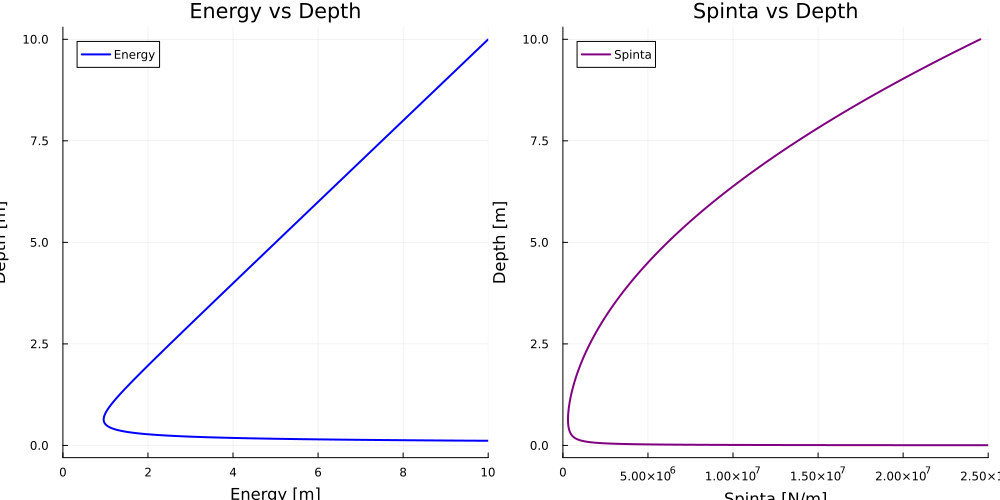

In [2]:
d = 0.0:0.001:10.0          # depths of the channel [m]
Q = 80.0                    # discharge [m^3/s]
B = 50.0                    # width of the channel [m]
ρ = 1000.0                  # water density [kg/m^3]
g = 9.81                    # gravity acceleration [m/s^2]

Spinta(Q, B, d, g, ρ) = @. 0.5*ρ*g*B*d^2 + ρ*Q^2/(B*d)
Energy(Q, B, d) = @. d + Q^2/(2*g*(B*d)^2)

S = zeros(length(d))        # water surface elevation [m]
E = zeros(length(d))        # energy elevation [m]
S .= Spinta(Q, B, d, g, ρ)      # calculate Spinta for each depth
E .= Energy(Q, B, d)            # calculate Energy for each depth

#=
S = zeros(length(d))        # water surface elevation [m]
E = zeros(length(d))        # energy elevation [m]
for n in 1:length(d)
    S[n] = Spinta(Q, B, d[n], g, ρ)
    E[n] = Energy(Q, B, d[n])
end
=#
p1 = plot_1D(S, d, (0, 2.5e7); lab="Spinta", xlab="Spinta [N/m]", ylab="Depth [m]",
    ttl="Spinta vs Depth", cl="purple", grid=true)
p2 = plot_1D(E, d, (0, 10); lab="Energy", xlab="Energy [m]", ylab="Depth [m]",
    ttl="Energy vs Depth", cl="blue", grid=true)
#=
p1 = plot(S, d, label="Spinta", xlabel="Spinta [N/m]", ylabel="Depth [m]",
    title="Spinta vs Depth", grid=true, color="purple", linewidth=2,
    xlim=(0, 2.5e7))
p2 = plot(E, d, label="Energy", xlabel="Energy [m]", ylabel="Depth [m]",
    title="Energy vs Depth", grid=true, color="blue", linewidth=2,
    xlim=(0, 10)) =#
    
plot(p2, p1, layout=(1, 2), size=(1000, 500))



The fact that two solutions are at the same time valid make crucial the choice of the side in which to set the BC: subcritical flows are governed by downstream, fast flows are governed by upstream. This means that in principle there are always two valid solution, the first evaluated starting from upstream and the second evaluated from downstream. So, which of the two must be chosen (without enter the computation any time)? The real one is the one that present the greatest Spinta!  

### Implementing procedure
The codes are provided in Julia. The steps for the implementations are the following:
1) Build the geometry and define the $dx$;
2) Solve the Energy ODE (two times) to obtain an Energy profile along the river;
3) Calculate the 2 normal depths for any section;
4) Calculate the Specific Force $S$ for both the depths for each section;
5) Assign the depth with the greatest $S$ between the two (disxrimination between fast/slow flows).
6) Include local discontinuities. 

## Single reach, uniform flow

Number of points along the channel: 1001
first and last x coordinates: 0.0 m, 1000.0 m
first and last z coordinates: 1.0 m, 0.0 m
Uniform depths: 1.3442504755894709 m, Critical depths: 0.7415327354153678 m
Left downward Energy = 1.4570742412056268 m, Right downward Energy = 1.4570753087912023 m
Left upward Energy = 1.4570742412056268 m, Right upward Energy = 1.4570753087912023 m
Spinta for the supercritical depths: 494173.0168461898 N/m, with depth: 0.4499146862204148 m
Spinta for the subcritical depths: 591955.5903478508 N/m, with depth: 1.344259139077015 m


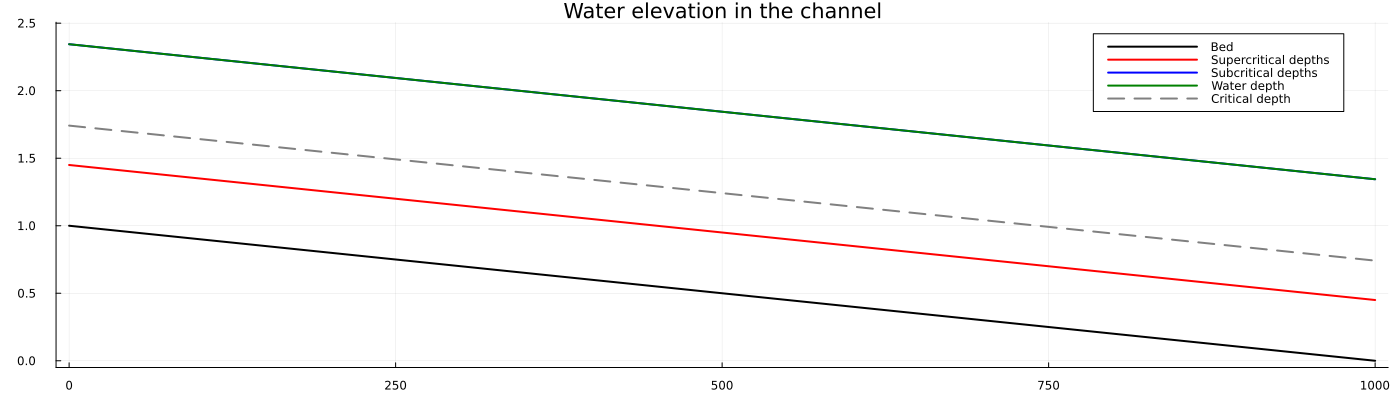

In [3]:
# ---------------------- PROBLEM DEFINITION -----------------------

L  = 1000.0       # length of the channel [m]
Q  = 100.0        # discharge [m^3/s] Q = Ω Ks R^2/3 iF^1/2
B  = 50.0         # width of the channel [m]
Ks = 40.0         # Strickler coefficient [m^(1/3)/s] Ks = 1/n
iF = 0.001         # slope of the channel
dx = 1.0          # distance between the points of the channel [m]
g  = 9.81         # gravity acceleration [m/s^2]

# -------------------------- GEOMETRY -----------------------------

# Check the length of the channel is a multiple of dx
L % dx ≠ 0 && error("The length of the channel must be a multiple of dx")
n_points = Int(L/dx) + 1                                    # number of points in the channel
println("Number of points along the channel: ",  n_points)

X = LinRange(0, L, n_points)                                # x coordinates of the points
Z = zeros(n_points)                                         # initialize z coordinates of the points
build_bed!(Z, X, dx, iF, n_points) # build the bed of the channel
println("first and last x coordinates: ", X[begin], " m, ", X[end], " m")
println("first and last z coordinates: ", Z[begin], " m, ", Z[end], " m")

# --------------------- BOUNDARY CONDITIONS ------------------------

# Evaluate the uniform and critical depths
d_uniform, d_critical = evaluate_depths(Q, B, L, Ks, iF)    # evaluate the uniform and critical depths
d_critical_vector = d_critical[1] * ones(length(X))         # vector of critical depths, same length as X
println("Uniform depths: ", d_uniform, " m, Critical depths: ", d_critical, " m")

# The BC are always the uniform flow depth:
eL = d_uniform + Q^2 / (2 * g * (B * d_uniform)^2) # water elevation at the left boundary [begin]
eR = d_uniform + Q^2 / (2 * g * (B * d_uniform)^2) # water elevation at the left boundary [end]

# ------------------------- INTEGRATION -----------------------------

# Solve the energy equation from left to right (downward)
e_dw = zeros(n_points)                          # energy E at the points of the channel
e_dw[1] = eL                                    # initial condition at the left boundary
for n in 2:n_points
    # Evaluate the hydraulic radius:
    Rh = (B[1] * d_uniform[1])/(2*d_uniform[1] + B[1])
    # Evaluate the Energy (forward explicit Euler)
    e_dw[n] = e_dw[n-1] - dx * (iF[1] - (Q/(Ks * B[1] * d_uniform[1]))^2 * Rh^(-4/3))
end
println("Left downward Energy = ", e_dw[1], " m, Right downward Energy = ", e_dw[n_points], " m")

# Solve the energy equation from right to left (upward)
e_uw = zeros(n_points)                          # energy E at the points of the channel
e_uw[n_points] = eR                              # initial condition at the right boundary        
for n in n_points-1:-1:1
    # Evaluate the hydraulic radius:
    Rh = (B[1] * d_uniform[1])/(2*d_uniform[1] + B[1])
    # Evaluate the Energy (forward explicit Euler)
    e_uw[n] = e_uw[n+1] - dx * (iF[1] - (Q/(Ks * B[1] * d_uniform[1]))^2 * Rh^(-4/3))
end
println("Left upward Energy = ", e_dw[1], " m, Right upward Energy = ", e_dw[n_points], " m")

# ------------------------- DEPTHS EVALUATION -----------------------

# From the solution of the energy abstract two depths:
d_fast = zeros(n_points)            # depth from the downward energy
d_slow = zeros(n_points)            # depth from the upward energy   
for n = 1:n_points
    d_fast[n] = E2d_single_reach(d_critical, Q, B, e_dw[n], style="supercritical")
    d_slow[n] = E2d_single_reach(d_critical, Q, B, e_uw[n], style="subcritical")
end

# ------------------------- SPINTA EVALUATION -----------------------

# evaluate the Spinta for both the supercritical and subcritical depths
Spinta_fast = zeros(n_points)                   # Spinta for the supercritical depths  
Spinta_slow = zeros(n_points)                   # Spinta for the subcritical depths
for n = 1:n_points
    Spinta_fast[n] = Spinta(Q, B, d_fast[n])    # Spinta for the supercritical depths
    Spinta_slow[n] = Spinta(Q, B, d_slow[n])    # Spinta for the subcritical depths
end
println("Spinta for the supercritical depths: ", Spinta_fast[1], " N/m, with depth: ", d_fast[1], " m")
println("Spinta for the subcritical depths: ", Spinta_slow[1], " N/m, with depth: ", d_slow[1], " m")

# Chose the depth with the maximum Spinta between the two:
d = zeros(n_points)                              # final depth to be plotted
for n = 1:n_points
    # use the supercritical depth if Spinta is greater, otherwise use the subcritical depth
    Spinta_fast[n] > Spinta_slow[n] ? d[n] = d_fast[n] : d[n] = d_slow[n] 
end

# --------------------------- PLOTS -----------------------------

y_limits = (min(minimum(Z), minimum(e_dw)) - 0.05, max(maximum(Z), maximum(Z+e_dw)) + 0.05)
p1 = plot(X, Z, label="Bed", xlabel="x [m]", ylabel="z [m]", title="Bed of the channel", legend=:topright,
    grid=true, xlims=(X[begin]-10, X[end]+10), ylims=y_limits, color="black", linewidth=2,
    size=(1400, 400))
p1 = plot!(X, Z + d_fast, label="Supercritical depths", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="red", linewidth=2)
p1 = plot!(X, Z + d_slow, label="Subcritical depths", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="blue", linewidth=2)
p1 = plot!(X, Z + d, label="Water depth", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="green", linewidth=2)
p1 = plot!(X, Z + d_critical_vector, label="Critical depth", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="gray", linewidth=2, linestyle=:dash)
display(p1)


As can be seen from the plot above, a case like that leads to the situation in which there is always subcritical flow even if the evaluated normal depth is smaller than the critical one, this comes from the comparison of the Spinta of the two solutions: they both start from the same Energy value, so they both lead to the same situation, the energy value itself is correct, it is not correct the location of the imposition, in fact, looking at the plot:
  
![Why so far it doesn't work properly](images/Spinta_energia.PNG)
  
It is clear that for two depths with the same energy (that is the case) the depth producing subcritical flow present a greater Spinta, always!  
So, the problem is not the energy value (there are no reasons to impose different values) but in the location the imposed BC.

## Multiple reaches

In [ ]:
# ---------------------- PROBLEM DEFINITION -----------------------

n_reaches = 3               # number of reaches in the channel
L  = [1000.0, 2000.0, 1000.0]       # length of the channel [m]
Q  = 100.0                  # discharge [m^3/s] Q = Ω Ks R^2/3 iF^1/2
B  = [50.0, 50.0, 50.0]           # width of the channel [m]
Ks = [40.0, 40.0, 40.0]           # Strickler coefficient [m^(1/3)/s] Ks = 1/n
iF = [0.01, 0.001, 0.0005]          # slope of the channel
dx = 10.0                   # distance between the points of the channel [m]
g  = 9.81                   # gravity acceleration [m/s^2]

# -------------------------- GEOMETRY -----------------------------

n_points = Array{Int64}(undef, n_reaches)                                     # number of points in the channel
for n_rea in 1:n_reaches
    # Check the lengths of the channel are multiple of dx
    L[n_rea] % dx ≠ 0 && error("The length of the channel must be a multiple of dx")
    n_points[n_rea] = Int(L[n_rea]/dx) + 1
    @printf("Number of points along reach %d: %d \n", n_rea, n_points[n_rea])
end

n_points_total = sum(n_points)                              # total number of points in the channel
@printf("Total number of points in the channel: %d \n", n_points_total)

B_v = Array{Float64}(undef, n_points_total)                                  # temporary array for the widths
KS  = Array{Float64}(undef, n_points_total)                               # temporary array for the Strickler coefficients
IF  = Array{Float64}(undef, n_points_total)  

dX = dx .* ones(n_points_total-1)                            # vector of distances between the points
B_v[1:n_points[1]] = B[1] .* ones(n_points[1])                     # vector of widths, same length as X
KS[1:n_points[1]] = Ks[1] .* ones(n_points[1])                     # vector of Strickler coefficients
IF[1:n_points[1]] = iF[1] .* ones(n_points[1])                     # vector of slopes
for n_rea in 1:n_reaches-1
    location = sum(n_points[1:n_rea]) + 1                     # location of the first point of the next reach
    dX[location] = 0.0 # set the last distance to zero, to avoid problems in the integration
    B_v[sum(n_points[1:n_rea])+1: sum(n_points[1:n_rea+1])] = B[n_rea+1] .* ones(n_points[n_rea+1]) # vector of widths, same length as X
    KS[sum(n_points[1:n_rea])+1 : sum(n_points[1:n_rea+1])] = Ks[n_rea+1] .* ones(n_points[n_rea+1]) # vector of Strickler coefficients
    IF[sum(n_points[1:n_rea])+1 : sum(n_points[1:n_rea+1])] = iF[n_rea+1] .* ones(n_points[n_rea+1]) # vector of slopes
end

println("size B_v =  ", size(B_v), ", size KS = ", size(KS), ", size IF = ", size(IF), ", size dX = ", size(dX))

# Check the dX vector is corrected (must be present some zeros)
pdx = scatter(dX, label="dX", xlabel="Point index", ylabel="dX [m]",
    title="Distance between the points", grid=true, color="black",
    xlims=(1, n_points_total), size=(1000, 400)); # display(pdx)    
# savefig("pdx_plot.png")

# auxiliary vectors
scale = zeros(n_reaches, 2)
for n_rea in n_reaches-1:-1:1
    scale[n_rea, 2] = scale[n_rea+1, 2] + L[n_rea+1] * iF[n_rea+1]        # scale vector for the z coordinates
end
for n_rea in 2:n_reaches
    scale[n_rea, 1] = scale[n_rea-1, 1] + L[n_rea-1]                      # scale vector for the x coordinates
end

println("Scale vector for X: ", scale[:, 1])
println("Scale vector for Z: ", scale[:, 2])



X = Array{Float64}(undef, n_points_total)                       # initialize the array for the x coordinates of the points
Z = Array{Float64}(undef, n_points_total)                       # initialize the arrays for the x and z coordinates of the points
for n_rea in 1:n_reaches
    x = LinRange(0, L[n_rea], n_points[n_rea])                  # x coordinates of the points
    z = zeros(n_points[n_rea])                                  # initialize z coordinates of the points
    build_bed!(z, x, dx, iF[n_rea], n_points[n_rea])            # build the bed of the channel
    if n_rea == 1
        X[1:n_points[n_rea]] = x .+ scale[n_rea, 1]                                                        # first reach, assign the x coordinates
        Z[1:n_points[n_rea]] = z .+ scale[n_rea, 2]                                        # first reach, assign the z coordinates with the scale
    else
        X[sum(n_points[1:n_rea-1])+1 : sum(n_points[1:n_rea])] = x .+ scale[n_rea, 1]   # append the x coordinates
        Z[sum(n_points[1:n_rea-1])+1 : sum(n_points[1:n_rea])] = z .+ scale[n_rea, 2]   # append the z coordinates with the scale
    end
end

println("first and last x coordinates: ", X[1], " m, ", X[end], " m")
println("first and last z coordinates: ", Z[1], " m, ", Z[end], " m")

pbed = plot(X, Z, label="Bed", xlabel="x [m]", ylabel="z [m]", title="Bed of the channel",
    grid=true, xlims=(X[begin]-10, X[end]+10), ylims=(minimum(Z)-0.05, maximum(Z)+0.05),
    color="black", linewidth=2, size=(1000, 400)); # display(pbed)


px   = plot(X, label="X coordinates", xlabel="Point index", ylabel="X [m]",
    title="X coordinates of the points", grid=true, color="blue",
    xlims=(1, n_points_total), size=(1000, 400))
# display(plot(pbed, px, layout=(2,1), size=(1000, 800), legend=:topright)) 


# --------------------- BOUNDARY CONDITIONS ------------------------

# Evaluate the uniform and critical depths
d_uniform, d_critical = zeros(n_reaches), zeros(n_reaches)    # initialize the vectors for the uniform and critical depths
for n_rea in 1:n_reaches
    d_uniform[n_rea], d_critical[n_rea] = evaluate_depths(Q, B[n_rea], L[n_rea], Ks[n_rea], iF[n_rea])    # evaluate the uniform and critical depths
    # append the critical depth vector
    println("Reach ", n_rea, ": Uniform depth = ", d_uniform[n_rea], " m, Critical depth = ", d_critical[n_rea], " m")
end

# fill the critical depth vector with the values for each reach
d_critical_vector = zeros(n_points_total)                     # initialize the vector for the critical depths
d_critical_vector[1:n_points[1]] = d_critical[1] .* ones(n_points[1]) # first reach, assign the critical depth
for n_rea in 2:n_reaches
    d_critical_vector[sum(n_points[1:n_rea-1])+1 : sum(n_points[1:n_rea])] = d_critical[n_rea] .* ones(n_points[n_rea]) # append the critical depth
end
# d_critical_vector = n_rea == 1 ? d_critical[n_rea] .* ones(n_points[n_rea]) : vcat(d_critical_vector, d_critical[n_rea] .* ones(n_points[n_rea])) 


# The BC are always the uniform flow depth:
eL = d_uniform[begin] + Q^2 / (2 * g * (B[begin] * d_uniform[begin])^2) # water elevation at the left boundary [begin]
eR = d_uniform[end] + Q^2 / (2 * g * (B[end] * d_uniform[end])^2) # water elevation at the left boundary [end]
println("Left E BC = ", eL, " m, Right E BC = ", eR, " m")

# ------------------------- INTEGRATION ----------------------------- 
# NB: here we have to solve for E and immediately evaluate the depths from the energy


# Solve the energy equation from left to right (downward)
e_dw = zeros(n_points_total); e_dw[1] = eL                      # energy E at the points of the channel + IC
d_fast = zeros(n_points_total); d_fast[1] = d_uniform[begin]    # depth from the downward energy + IC
for n in 2:n_points_total
    if d_fast[n-1] == 0.0
        @printf("Warning: d_fast[%d] = %.2f m, set to critical: d_fast[%d] = %.3f m \nBreaking the supercritical computation  \n", n-1, d_fast[n-1], n-1, d_critical_vector[n-1])
        d_fast[n-1] = d_critical_vector[n-1] # set the depth to the critical depth
        break
    end
    e_dw[n] = e_dw[n-1] + dX[n-1] * dEdx(IF[n-1], Q, B_v[n-1], d_fast[n-1], KS[n-1])
    # Evaluate the depth from the energy
    d_fast[n] = E2d(d_critical_vector[n], Q, B_v[n], e_dw[n], style="supercritical")
    @printf("n = %d, e_dw[n] = %f, d_fast[n] = %.4f, X[n] = %.2f \n", n, e_dw[n], d_fast[n], X[n])
end
println("Supercritical computation: Left downward Energy = ", e_dw[1], " m, Right downward Energy = ", e_dw[n_points_total], " m")


# Solve the energy equation from right to left (upward)
e_uw = zeros(n_points_total); e_uw[end] = eR                    # energy E at the points of the channel + IC
d_slow = zeros(n_points_total); d_slow[end] = d_uniform[end]    # depth from the upward energy + IC
for n in n_points_total-1:-1:1
    if d_slow[n+1] == 0.0
        @printf("Warning: d_slow[%d] = %.2f m, set it to critical: d_slow[%d] = %.3f m \nbreaking the subcritical computation  \n", n+1, d_slow[n+1], n+1, d_critical_vector[n+1])
        d_slow[n+1] = d_critical_vector[n+1] # set the depth to the critical depth
        break
    end
    # Evaluate the Energy (forward explicit Euler)
    e_uw[n] = e_uw[n+1] - dX[n] * dEdx(IF[n+1], Q, B_v[n+1], d_slow[n+1], KS[n+1])
    @infiltrate false
    d_slow[n] = E2d(d_critical_vector[n], Q, B_v[n], e_uw[n], style="subcritical")
    @printf("n = %d, e_uw[n] = %f, d_slow[n] = %.4f, X[n] = %.2f \n", n, e_uw[n], d_slow[n], X[n])
end
println("Subcritical computation: Left upward Energy = ", e_uw[1], " m, Right upward Energy = ", e_uw[n_points_total], " m")

# ------------------------- SPINTA EVALUATION -----------------------

# evaluate the Spinta for both the supercritical and subcritical depths
Spinta_fast = zeros(n_points_total)                   # Spinta for the supercritical depths  
Spinta_slow = zeros(n_points_total)                   # Spinta for the subcritical depths
d = zeros(n_points_total)                             # final depth to be plotted
for n = 1:n_points_total
    Spinta_fast[n] = d_fast[n]==0 ? 0 : Spinta(Q, B_v[n], d_fast[n])    # Spinta for the supercritical depths
    Spinta_slow[n] = d_slow[n]==0 ? 0 : Spinta(Q, B_v[n], d_slow[n])    # Spinta for the subcritical depths
    # use the supercritical depth if Spinta is greater, otherwise use the subcritical depth
    Spinta_fast[n] > Spinta_slow[n] ? d[n] = d_fast[n] : d[n] = d_slow[n] 
end
#println("Spinta for the supercritical depths: ", Spinta_fast[1], " N/m, with depth: ", d_fast[1], " m")
#println("Spinta for the subcritical depths: ", Spinta_slow[1], " N/m, with depth: ", d_slow[1], " m")

# --------------------------- PLOTS -----------------------------

y_limits = (min(minimum(Z), minimum(e_dw)) - 0.05, max(maximum(Z), maximum(Z+e_dw)) + 0.05)
p1 = plot(X, Z, label="Bed", xlabel="x [m]", ylabel="z [m]", title="Bed of the channel", legend=:topright,
    grid=true, xlims=(X[begin]-10, X[end]+10), ylims=y_limits, color="black", linewidth=2,
    size=(1400, 700))
p1 = plot!(X, Z + d_fast, label="Supercritical depths", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="red", linewidth=2)
p1 = plot!(X, Z + d_slow, label="Subcritical depths", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="blue", linewidth=2)
p1 = plot!(X, Z + d, label="Water depth", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="green", linewidth=2)
p1 = plot!(X, Z + d_critical_vector, label="Critical depth", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="gray", linewidth=2, linestyle=:dash)

p2 = plot(X, Z, label="Bed", xlabel="x [m]", ylabel="z [m]", title="Bed of the channel", legend=:topright,
    grid=true, xlims=(900, 1050), ylims=(Z[100]-2, Z[100]+d_slow[100]+1), color="black", linewidth=2,
    size=(1400, 700))
p2 = plot!(X, Z + d_fast, label="Supercritical depths", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="red", linewidth=2)
p2 = plot!(X, Z + d_slow, label="Subcritical depths", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="blue", linewidth=2)
p2 = plot!(X, Z + d, label="Water depth", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="green", linewidth=2)
p2 = plot!(X, Z + d_critical_vector, label="Critical depth", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="gray", linewidth=2, linestyle=:dash)

display(plot(p1, p2, layout=(2,1), size=(1400, 800)))



The implementation in this way is not general, the case steep-mild is the only one that works, because it allow to impose the BC properly. To make the code generally working the possibility to impose internal BC must be implemented, because fast flows need BC from upstream and slow flows need BC from downstream.  
The integration have to be performed not along the total number of points, but reach to reach and estending the integration until reaching the critical level (The energy solution explodes).

